In [27]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from utils.utils_embedding import evaluate, dataframe_results, plot_embeddings, create_set_embeddings, load_qa_dataset
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sentence_transformers import util

In [ ]:
top_k = 3
dataset_name = "QA/tinyllama_11b_dataset.json"
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
num_pca_componets = 2
num_epochs = 2
finetuned_filename = "finetuned_model"

In [29]:
it_dataset = load_qa_dataset(dataset_name)

2025-07-15 18:08:28.552 | INFO     | utils.utils_embedding:load_qa_dataset:15 - Loading dataset from QA/tinyllama_11b_dataset.json


In [30]:
embed_model_paraphrase_l12 = HuggingFaceEmbedding(model_name=model_name)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [31]:
df_no_finetuned_results_it = evaluate(dataset=it_dataset, 
                                        embed_model=embed_model_paraphrase_l12, 
                                        top_k=top_k, 
                                        verbose=True)
print(len(df_no_finetuned_results_it))
df_no_finetuned_results_it.tail(10)

100%|██████████| 222/222 [00:02<00:00, 85.78it/s]

222


,is_hit,mrr,retrieved,expected,query
212,False,0.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",a2ce51f1-e2d7-437e-a9ae-d7ac5250b69f,ab897bcd-78bb-456d-b748-a1cf1fc16d61
213,False,0.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",bb6eee1f-b0e3-447c-8e5e-be8553379e68,bbcca493-b5fc-484c-a6de-6b3dea72d2cd
214,False,0.0,"[d82d64af-990f-425c-a53a-88c2eb5d2543, 5885582...",df851b46-04f0-4171-810f-2b56c3d3a543,6893af2a-a42c-4046-bda1-e1f0ef8cafc6
215,False,0.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",37f030ab-6b37-493b-8602-0d633713ce9d,bf022219-729b-4c64-8fac-6165f0578e3b
216,True,1.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d,cce61b7e-79b8-4c33-884d-e97fd5042e16
217,True,0.5,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",81e0f7f6-81da-4d95-a9ea-da2ec858d50b,caabfb03-3eb8-42fc-9797-8fef7a42a58e
218,False,0.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",111984c6-e361-4909-9361-2e8d71ccd9ce,516b00db-4d75-4acb-b22f-767330d3370c
219,False,0.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",409c5888-b2df-49c0-935a-cbd5eb6b9702,93f4237a-116b-4ce0-8285-46ed9b41bcc7
220,False,0.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",9bd5af6e-ad11-4393-abcc-68075477b783,62582eca-01e4-4ecb-8df3-557d7abb15fe
221,False,0.0,"[6d648d9d-9ba5-4f7d-ab6c-82c56b243a1d, 81e0f7f...",0348cac9-27a2-406a-adc9-7fb6ad50662c,9f23e410-8266-43ee-9a42-d5db06e045f7


In [32]:
pca = PCA(n_components=num_pca_componets)
array_embeddings_paraphrase_l12_it = create_set_embeddings(it_dataset, embed_model_paraphrase_l12)
projected = pca.fit_transform(array_embeddings_paraphrase_l12_it)

100%|██████████| 222/222 [00:03<00:00, 68.86it/s]


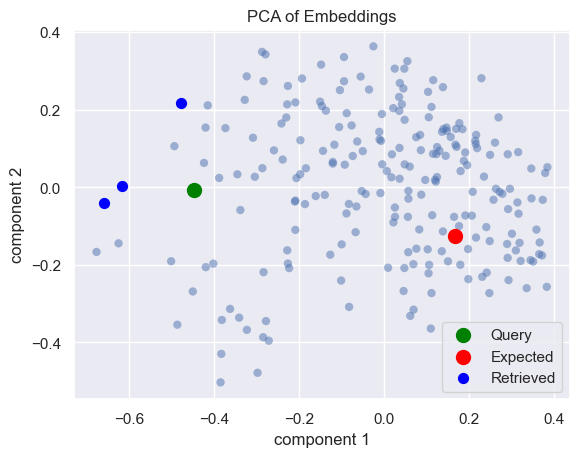

2025-07-15 18:10:30.666 | INFO     | __main__:<module>:18 - Mean cosine similarity between query and retrieved embeddings: 0.2939


In [42]:
from loguru import logger

query_id = 'ab897bcd-78bb-456d-b748-a1cf1fc16d61'

unmatch_query = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[unmatch_expected])
list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, projected, query_embedding, expected_embedding, list_retrieved_embedding)

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

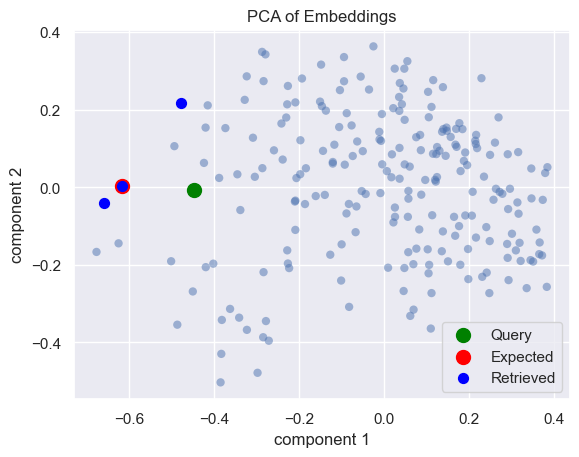

2025-07-15 18:10:33.218 | INFO     | __main__:<module>:16 - Mean cosine similarity between query and retrieved embeddings: 0.2939


In [43]:
query_id = 'caabfb03-3eb8-42fc-9797-8fef7a42a58e'

unmatch_query = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_no_finetuned_results_it[df_no_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[unmatch_expected])
list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, projected, query_embedding, expected_embedding, list_retrieved_embedding)

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

In [ ]:
from llama_index.finetuning import SentenceTransformersFinetuneEngine

finetune_engine = SentenceTransformersFinetuneEngine(
                                                    it_dataset,
                                                    model_id=model_name,
                                                    model_output_path=finetuned_filename,
                                                    val_dataset=it_dataset,
                                                    epochs=num_epochs
                                                    )

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [36]:
finetune_engine.finetune()
finetuned_embed_model = finetune_engine.get_finetuned_model()

/opt/homebrew/Caskroom/miniconda/base/envs/agent/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
23,No log,No log,0.063063,0.094595,0.112613,0.157658,0.063063,0.031532,0.022523,0.015766,0.063063,0.094595,0.112613,0.157658,0.103659,0.087341,0.098662


INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Information Retrieval Evaluation of the model on the  dataset in epoch 1.0 after 23 steps:
Information Retrieval Evaluation of the model on the  dataset in epoch 1.0 after 23 steps:
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Queries: 222
Queries: 222
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Corpus: 222

Corpus: 222

INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Score-Function: cosine
Score-Function: cosine
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@1: 6.31%
Accuracy@1: 6.31%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@3: 9.46%
Accuracy@3: 9.46%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@5: 11.26%
Accuracy@5: 11.26%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@10: 15.77%
Accuracy@10: 15.77%
INFO:sentence_transformers

In [37]:
df_finetuned_results_it = evaluate(dataset=it_dataset, 
                                        embed_model=finetuned_embed_model,
                                        top_k=top_k, 
                                        verbose=True)
print(len(df_finetuned_results_it))
df_finetuned_results_it.head()

100%|██████████| 222/222 [00:02<00:00, 77.51it/s]

222


,is_hit,mrr,retrieved,expected,query
0,False,0.0,"[33f4da8a-f244-4e41-93de-72aaef842920, 647036f...",6f4337e7-a282-495b-820f-07161b13ff1b,4a5f8c89-9b88-4561-bf6e-3bafe1692b36
1,False,0.0,"[33f4da8a-f244-4e41-93de-72aaef842920, 647036f...",920eeae0-924c-404b-ae42-99126fbecd23,5f7def8f-e9e6-4ae7-9cb1-7a92a123229f
2,False,0.0,"[33f4da8a-f244-4e41-93de-72aaef842920, 647036f...",4d836f4e-d0f1-4b0a-a612-6b605d201898,c21634e9-de58-4a34-aa6b-b9b3684403c5
3,False,0.0,"[6f4337e7-a282-495b-820f-07161b13ff1b, e9696c9...",23bbbebb-1924-49ab-a056-28968ca40805,6de238ce-74aa-47ac-bf35-f8182f5c9b6f
4,False,0.0,"[33f4da8a-f244-4e41-93de-72aaef842920, 647036f...",5949d0bc-df3d-4005-8251-b9e0d26c3064,ea60b4d9-debc-4976-bbc4-4562dbd20282


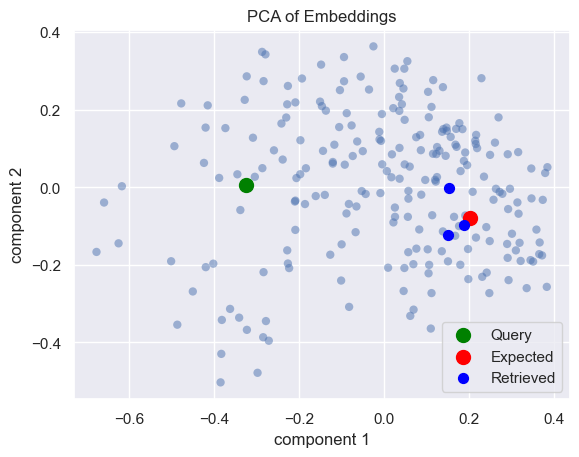

2025-07-15 18:10:48.663 | INFO     | __main__:<module>:15 - Mean cosine similarity between query and retrieved embeddings: 0.1813


In [44]:
query_id = 'ab897bcd-78bb-456d-b748-a1cf1fc16d61'
unmatch_query = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = finetuned_embed_model.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = finetuned_embed_model.get_text_embedding(it_dataset.corpus[unmatch_expected])
list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(finetuned_embed_model.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, projected, query_embedding, expected_embedding, list_retrieved_embedding)

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

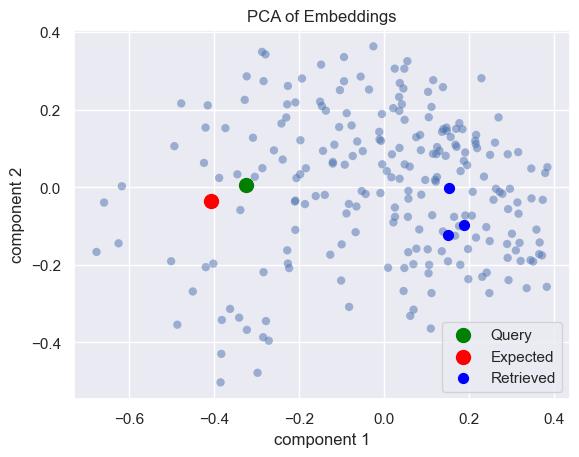

2025-07-15 18:11:00.228 | INFO     | __main__:<module>:16 - Mean cosine similarity between query and retrieved embeddings: 0.1813


In [45]:
query_id = 'caabfb03-3eb8-42fc-9797-8fef7a42a58e'

unmatch_query = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["query"].values[0]
unmatch_expected = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["expected"].values[0]
unmatch_retrieved = df_finetuned_results_it[df_finetuned_results_it["query"] == query_id]["retrieved"].values[0]

query_embedding = finetuned_embed_model.get_text_embedding(it_dataset.queries[unmatch_query])
expected_embedding = finetuned_embed_model.get_text_embedding(it_dataset.corpus[unmatch_expected])
list_retrieved_embedding = []
for i, retrieved in enumerate(unmatch_retrieved):
    list_retrieved_embedding.append(finetuned_embed_model.get_text_embedding(it_dataset.corpus[retrieved]))

plot_embeddings(pca, projected, query_embedding, expected_embedding, list_retrieved_embedding)

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")